In [38]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

In [39]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/b/b6/Felis_catus-cat_on_snow.jpg"  # Replace with actual image URL
image_path = tf.keras.utils.get_file("cat.jpg", origin=image_url)
img = PIL.Image.open(image_path)
img.show()


In [40]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

In [41]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

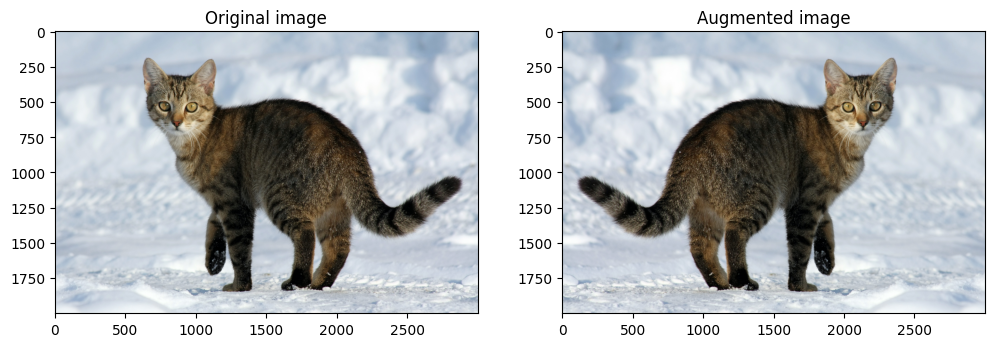

In [42]:
flipped=tf.image.flip_left_right(image)
visualize(image,flipped)

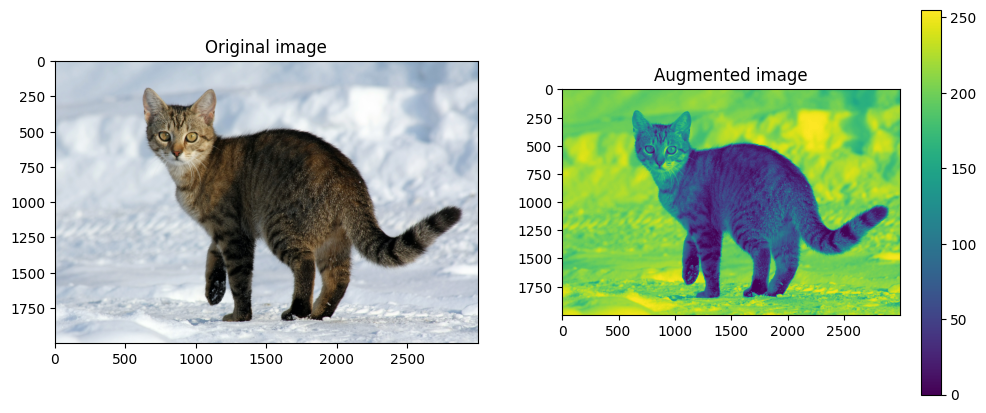

In [43]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image,grayscaled)
plt.colorbar()

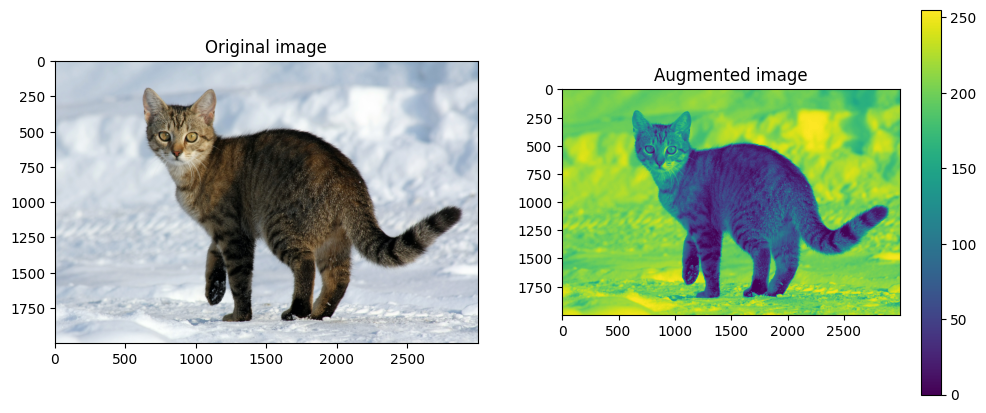

In [44]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

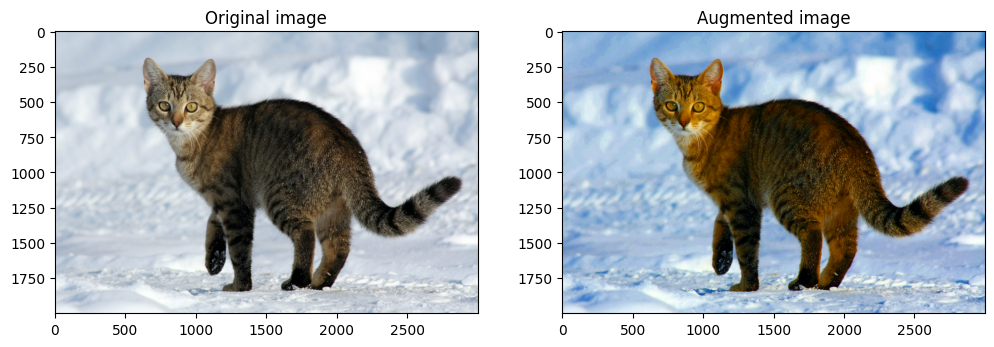

In [45]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

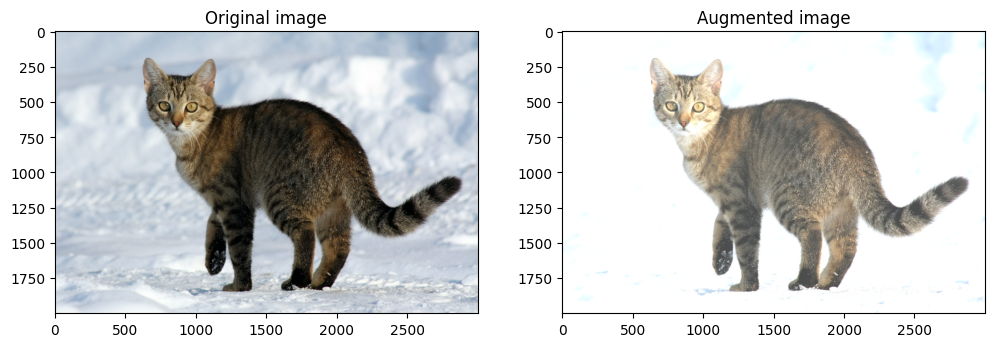

In [46]:
bright=tf.image.adjust_brightness(image,0.3)
visualize(image,bright)

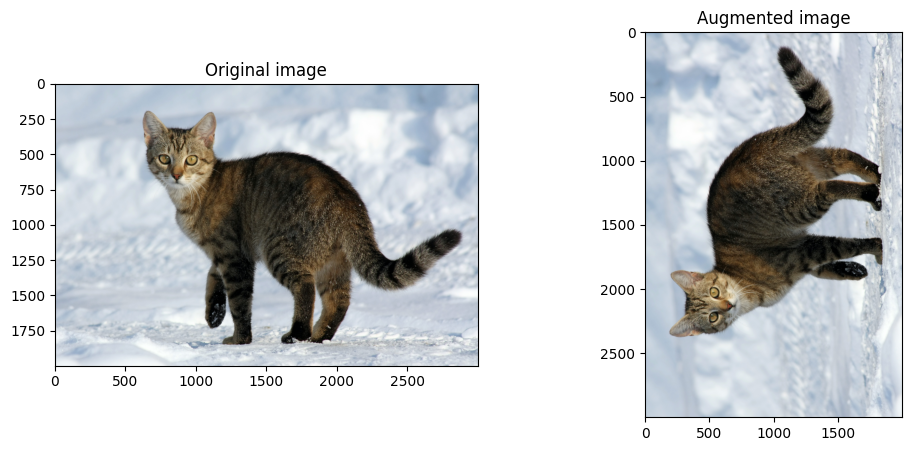

In [47]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

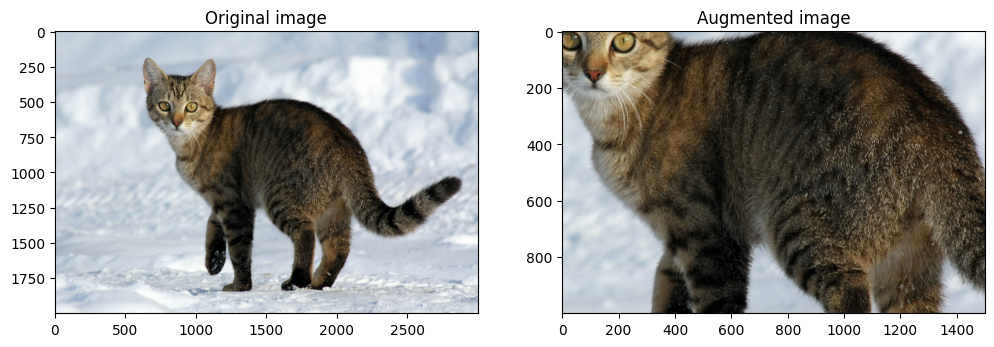

In [48]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

In [49]:
dataset,info=tfds.load('mnist',as_supervised=True,with_info=True)
train_dataset,test_dataset=dataset['train'],dataset['test']

num_train_examples=info.splits['train'].num_examples

C:\Users\antuk\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                         | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                         | 0/2 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                         | 0/3 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                         | 0/4 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|

Dataset mnist downloaded and prepared to C:\Users\antuk\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [50]:
def convert(image,label):
    image=tf.image.convert_image_dtype(image,tf.float32)
    return image,label

In [51]:
def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

In [54]:
augmented_train_batches=(
    train_dataset
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    .map(augment,num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)

    
)

In [55]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [56]:
validation_batches=(
    test_dataset
    .map(convert,num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [60]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [61]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50



32/32 [==============================] - 9s 243ms/step - loss: 0.8948 - accuracy: 0.7500 - val_loss: 0.3423 - val_accuracy: 0.8969
Epoch 2/50
32/32 [==============================] - 8s 241ms/step - loss: 0.2044 - accuracy: 0.9346 - val_loss: 0.3262 - val_accuracy: 0.9100
Epoch 3/50
32/32 [==============================] - 8s 238ms/step - loss: 0.0913 - accuracy: 0.9692 - val_loss: 0.3103 - val_accuracy: 0.9169
Epoch 4/50
32/32 [==============================] - 8s 237ms/step - loss: 0.0354 - accuracy: 0.9873 - val_loss: 0.2945 - val_accuracy: 0.9292
Epoch 5/50
32/32 [==============================] - 8s 239ms/step - loss: 0.0221 - accuracy: 0.9917 - val_loss: 0.3605 - val_accuracy: 0.9196
Epoch 6/50
32/32 [==============================] - 8s 241ms/step - loss: 0.0184 - accuracy: 0.9946 - val_loss: 0.3271 - val_accuracy: 0.9273
Epoch 7/50
32/32 [==============================] - 7s 235ms/step - loss: 0.0143 - accuracy: 0.9966 - val_loss: 0.3336 - val_accuracy: 0.9262
Epoch 8/50
32/32 

In [62]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 9s 244ms/step - loss: 2.3380 - accuracy: 0.3115 - val_loss: 1.2865 - val_accuracy: 0.5646
Epoch 2/50
32/32 [==============================] - 8s 248ms/step - loss: 1.3652 - accuracy: 0.5303 - val_loss: 0.7415 - val_accuracy: 0.7751
Epoch 3/50
32/32 [==============================] - 8s 237ms/step - loss: 0.9723 - accuracy: 0.6855 - val_loss: 0.4893 - val_accuracy: 0.8632
Epoch 4/50
32/32 [==============================] - 7s 237ms/step - loss: 0.7985 - accuracy: 0.7300 - val_loss: 0.3867 - val_accuracy: 0.8844
Epoch 5/50
32/32 [==============================] - 8s 248ms/step - loss: 0.6688 - accuracy: 0.7798 - val_loss: 0.3532 - val_accuracy: 0.8920
Epoch 6/50
32/32 [==============================] - 8s 240ms/step - loss: 0.6257 - accuracy: 0.7993 - val_loss: 0.3144 - val_accuracy: 0.9057
Epoch 7/50
32/32 [==============================] - 8s 247ms/step - loss: 0.5344 - accuracy: 0.8242 - val_loss: 0.2757 - val_accuracy: 0.9169
Epoch 

(0.75, 1.0)

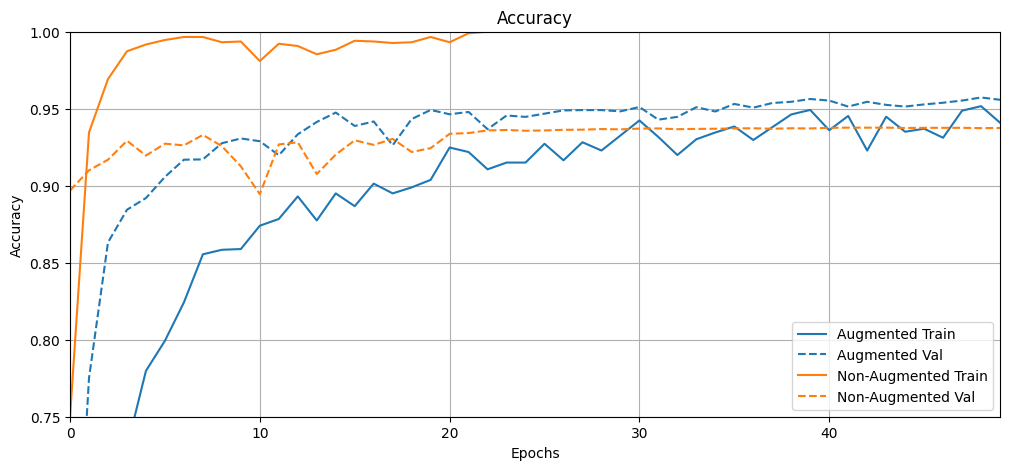

In [63]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])